In [3]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions_2 import *
from pdf2image import convert_from_path
from sklearn.manifold import TSNE
import statistics

### Soil Microbiome Figure 1

In [69]:
taxa_level = 'Genera'
table_name = 'tSoilMicrobe' + taxa_level
tables_to_join = [table_name, "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df = full_df.T.drop_duplicates().T
full_df.shape
full_df.rename(columns={'genera': 'taxa'}, inplace=True)
opdf = full_df.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='taxa', values='relative_abundance')
opdf = opdf.reset_index()
opdf = opdf.fillna(0)    
col_list1 = []
for i in opdf.columns:
    col_list1.append(i.split('|')[-1])
opdf.columns = col_list1
taxa_columns = opdf.columns
taxa_columns = taxa_columns.drop(['sample_id','site_id', 'species', 'V2'])

In [70]:
site_list = opdf['site_id']

opdf['BGR'] = site_list

opdf['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
opdf = opdf[opdf["BGR"].isin([0,1,2,3])]

opdf['BGR'] = opdf['BGR'].replace([0], 'Wintergreen')
opdf['BGR'] = opdf['BGR'].replace([1], 'Cole Mountain')
opdf['BGR'] = opdf['BGR'].replace([2], 'Blacksburg')
opdf['BGR'] = opdf['BGR'].replace([3], 'HR')

C:\Users\15404\AppData\Local\Temp\ipykernel_21180\921536217.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  opdf['BGR'] = site_list


In [71]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]

C:\Users\15404\AppData\Local\Temp\ipykernel_21180\1069200057.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['other'] = df3.sum(axis = 1).tolist()
C:\Users\15404\AppData\Local\Temp\ipykernel_21180\1069200057.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['other'] = df3.sum(axis = 1).tolist()
C:\Users\15404\AppData\Local\Temp\ipykernel_21180\1069200057.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

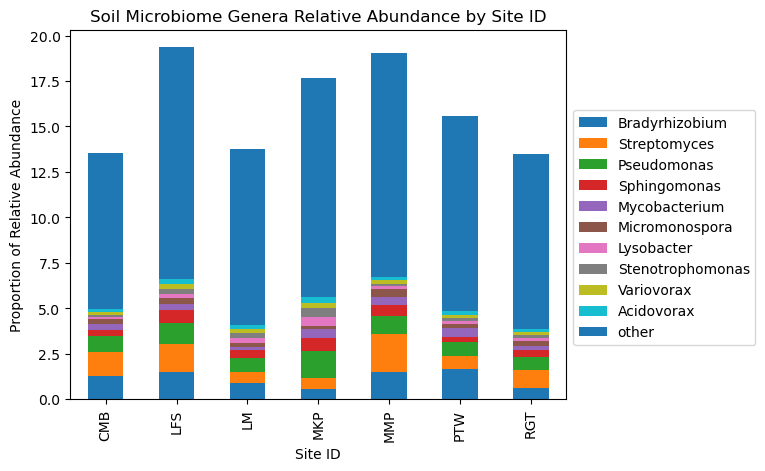

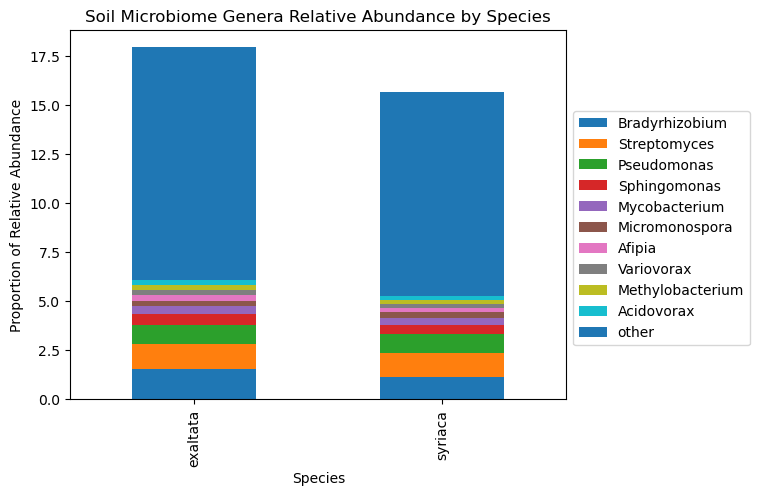

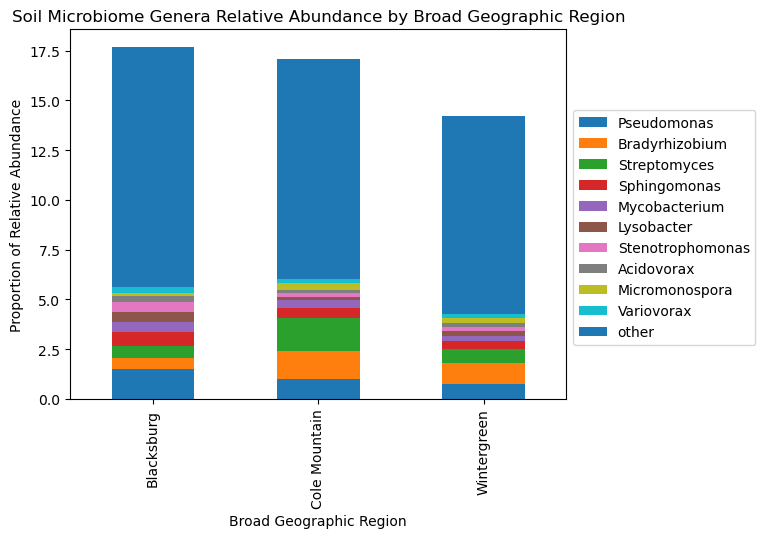

In [79]:
sort_list = ['site_id', 'species', 'BGR']
for sort_id in sort_list:
    df1 = opdf.groupby([sort_id])[taxa_columns].mean()
    df1 = df1.reset_index()
    new_columns = df1[taxa_columns].sum().nlargest(10)
    col_list = []
    for i in new_columns.axes[0]:
        col_list.append(i)
    col_list.append(sort_id)
    other_col = df1.columns
    other_col = other_col.drop(col_list)
    df2 = df1[col_list]
    df3 = df1[other_col]
    df2['other'] = df3.sum(axis = 1).tolist()
    ax = df2.plot.bar(x = sort_id, stacked=True)    
    
    name_dict = {'site_id': 'Site ID', 'species': 'Species', 'BGR': 'Broad Geographic Region'}
    graph_inf = name_dict[sort_id] 
    
    ax.set_xlabel(graph_inf)
    ax.set_ylabel('Proportion of Relative Abundance')
    ax.set_title('Soil Microbiome Genera Relative Abundance by ' + graph_inf)
    
    ax.legend(bbox_to_anchor=(1,0.8))
    
    if sort_id == 'site_id':
        plt.savefig('./soil_microbiome_figures/fig_1_a.pdf', dpi=300, bbox_inches='tight')
    elif sort_id == 'species':
        plt.savefig('./soil_microbiome_figures/fig_1_b.pdf', dpi=300, bbox_inches='tight')
    elif sort_id == 'BGR':
        plt.savefig('./soil_microbiome_figures/fig_1_c.pdf', dpi=300, bbox_inches='tight')

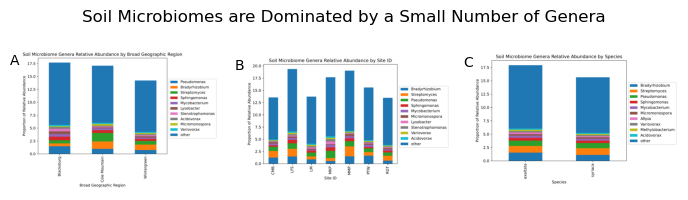

In [93]:
img1=convert_from_path('./soil_microbiome_figures/fig_1_a.pdf')
img2=convert_from_path('./soil_microbiome_figures/fig_1_b.pdf')
img3=convert_from_path('./soil_microbiome_figures/fig_1_c.pdf')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))

ax[0].imshow(img3[0])
ax[1].imshow(img1[0])
ax[2].imshow(img2[0])

# plot 2 subplots
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')


ax[0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Microbiomes are Dominated by a Small Number of Genera')
plt.tight_layout()
plt.show()

fig.savefig('./soil_microbiome_figures/figure_1.pdf', bbox_inches='tight', dpi = 1000)

### Soil Microbiome Figure 2

In [94]:
taxa_level = 'Genera'
table_name = 'tSoilMicrobe' + taxa_level
tables_to_join = [table_name, "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df = full_df.T.drop_duplicates().T
full_df.shape
full_df.rename(columns={'genera': 'taxa'}, inplace=True)
opdf = full_df.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='taxa', values='relative_abundance')

origin_pivoted_df = opdf.copy()
row_sum = origin_pivoted_df.sum(axis=1)

origin_pivoted_df = origin_pivoted_df.reset_index()

genera_col = origin_pivoted_df.columns
genera_col = genera_col.drop(['sample_id','site_id', 'species', 'V2'])

sub_pivot = origin_pivoted_df[genera_col].astype(float)

for row in range(sub_pivot.shape[0]):
    sub_pivot.loc[row] = sub_pivot.loc[row]/row_sum[row]

new_sum = sub_pivot.sum(axis=1)
new_sum

origin_pivoted_df[genera_col] = sub_pivot

origin_pivoted_df.head()

row_sum = origin_pivoted_df[genera_col].sum(axis=1)
print(row_sum)

opdf = origin_pivoted_df.copy()
opdf = opdf.reset_index()

opdf = opdf.fillna(0)  
col_list1 = []
for i in opdf.columns:
    col_list1.append(i.split('|')[-1])
opdf.columns = col_list1

taxa_columns = opdf.columns
taxa_columns = taxa_columns.drop(['sample_id','site_id', 'species', 'V2'])

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
151    1.0
152    1.0
153    1.0
154    1.0
155    1.0
Length: 156, dtype: float64


In [95]:
site_list = opdf['site_id']

opdf['BGR'] = site_list

opdf['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
opdf = opdf[opdf["BGR"].isin([0,1,2,3])]

opdf['BGR'] = opdf['BGR'].replace([0], 'Wintergreen')
opdf['BGR'] = opdf['BGR'].replace([1], 'Cole Mountain')
opdf['BGR'] = opdf['BGR'].replace([2], 'Blacksburg')
opdf['BGR'] = opdf['BGR'].replace([3], 'HR')

In [96]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]

In [97]:
#reshaped_df.columns.name = None
opdf.columns.name = None
opdf.head()

index sample_id site_id  species        V2  Candidatus Korarchaeum  \
0      0     CMB10     CMB  syriaca  0.999777                     0.0   
1      1     CMB11     CMB  syriaca  1.000000                     0.0   
2      2     CMB13     CMB  syriaca  0.989131                     0.0   
3      3     CMB15     CMB  syriaca  0.998548                     0.0   
4      4     CMB16     CMB  syriaca  0.999243                     0.0   

   Acidilobus  Caldisphaera  Aeropyrum  Desulfurococcus  ...  Iridovirus  \
0         0.0           0.0   0.000048              0.0  ...         0.0   
1         0.0           0.0   0.000000              0.0  ...         0.0   
2         0.0           0.0   0.000000              0.0  ...         0.0   
3         0.0           0.0   0.000000              0.0  ...         0.0   
4         0.0           0.0   0.000000              0.0  ...         0.0   

   Phix174microvirus  Hokovirus  Klosneuvirus  Tupanvirus  Alphapartitivirus  \
0                0.0        0.0       0.00000         0.0                0.0   
1                0.0        0.0       0.00000         0.0                0.0   
2                0.0        0.0       0.00000         0.0                0.0   
3                0.0        0.0       0.00000         0.0                0.0   
4                0.0        0.0       0.00018         0.0                0.0   

   Bracovirus  Pandoravirus            BGR  seq_id  
0         0.0           0.0  Cole Mountain       3  
1         0.0           0.0  Cole Mountain       3  
2         0.0           0.0  Cole Mountain       3  
3         0.0           0.0  Cole Mountain       3  
4         0.0           0.0  Cole Mountain       3  

[5 rows x 2533 columns]

In [98]:
opdf = opdf.drop(['index'], axis = 1)
opdf.head()

sample_id site_id  species        V2  Candidatus Korarchaeum  Acidilobus  \
0     CMB10     CMB  syriaca  0.999777                     0.0         0.0   
1     CMB11     CMB  syriaca  1.000000                     0.0         0.0   
2     CMB13     CMB  syriaca  0.989131                     0.0         0.0   
3     CMB15     CMB  syriaca  0.998548                     0.0         0.0   
4     CMB16     CMB  syriaca  0.999243                     0.0         0.0   

   Caldisphaera  Aeropyrum  Desulfurococcus  Ignicoccus  ...  Iridovirus  \
0           0.0   0.000048              0.0         0.0  ...         0.0   
1           0.0   0.000000              0.0         0.0  ...         0.0   
2           0.0   0.000000              0.0         0.0  ...         0.0   
3           0.0   0.000000              0.0         0.0  ...         0.0   
4           0.0   0.000000              0.0         0.0  ...         0.0   

   Phix174microvirus  Hokovirus  Klosneuvirus  Tupanvirus  Alphapartitivirus  \
0                0.0        0.0       0.00000         0.0                0.0   
1                0.0        0.0       0.00000         0.0                0.0   
2                0.0        0.0       0.00000         0.0                0.0   
3                0.0        0.0       0.00000         0.0                0.0   
4                0.0        0.0       0.00018         0.0                0.0   

   Bracovirus  Pandoravirus            BGR  seq_id  
0         0.0           0.0  Cole Mountain       3  
1         0.0           0.0  Cole Mountain       3  
2         0.0           0.0  Cole Mountain       3  
3         0.0           0.0  Cole Mountain       3  
4         0.0           0.0  Cole Mountain       3  

[5 rows x 2532 columns]

In [99]:
opdf = opdf.reset_index(drop=True)
opdf.head()

sample_id site_id  species        V2  Candidatus Korarchaeum  Acidilobus  \
0     CMB10     CMB  syriaca  0.999777                     0.0         0.0   
1     CMB11     CMB  syriaca  1.000000                     0.0         0.0   
2     CMB13     CMB  syriaca  0.989131                     0.0         0.0   
3     CMB15     CMB  syriaca  0.998548                     0.0         0.0   
4     CMB16     CMB  syriaca  0.999243                     0.0         0.0   

   Caldisphaera  Aeropyrum  Desulfurococcus  Ignicoccus  ...  Iridovirus  \
0           0.0   0.000048              0.0         0.0  ...         0.0   
1           0.0   0.000000              0.0         0.0  ...         0.0   
2           0.0   0.000000              0.0         0.0  ...         0.0   
3           0.0   0.000000              0.0         0.0  ...         0.0   
4           0.0   0.000000              0.0         0.0  ...         0.0   

   Phix174microvirus  Hokovirus  Klosneuvirus  Tupanvirus  Alphapartitivirus  \
0                0.0        0.0       0.00000         0.0                0.0   
1                0.0        0.0       0.00000         0.0                0.0   
2                0.0        0.0       0.00000         0.0                0.0   
3                0.0        0.0       0.00000         0.0                0.0   
4                0.0        0.0       0.00018         0.0                0.0   

   Bracovirus  Pandoravirus            BGR  seq_id  
0         0.0           0.0  Cole Mountain       3  
1         0.0           0.0  Cole Mountain       3  
2         0.0           0.0  Cole Mountain       3  
3         0.0           0.0  Cole Mountain       3  
4         0.0           0.0  Cole Mountain       3  

[5 rows x 2532 columns]

In [100]:
taxa_columns = taxa_columns.drop('index')

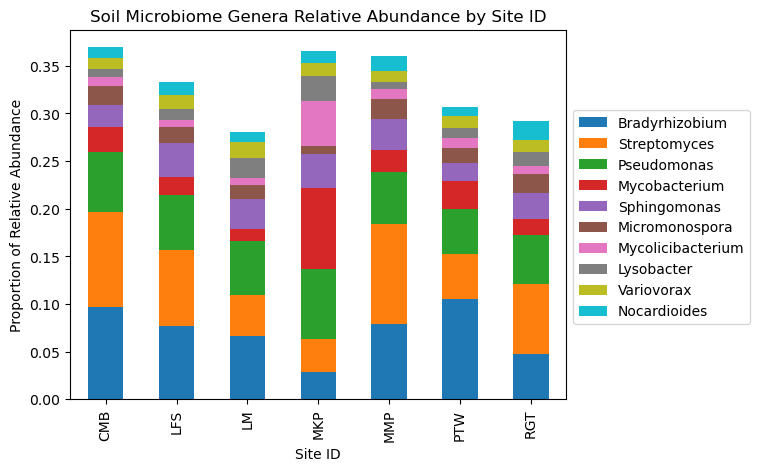

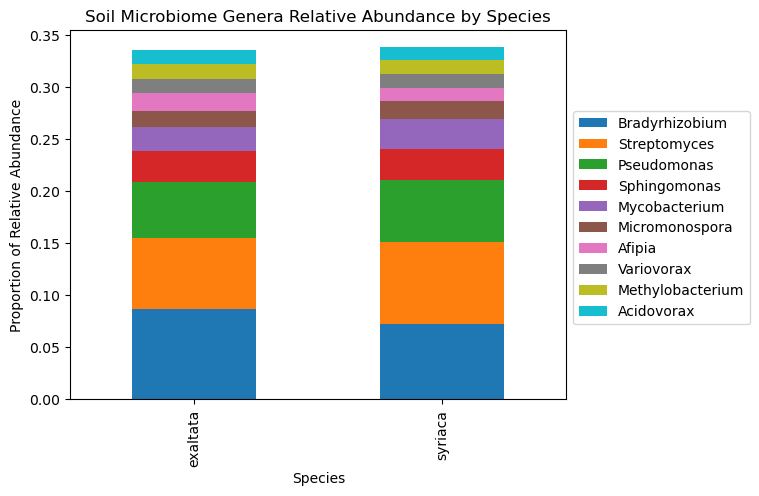

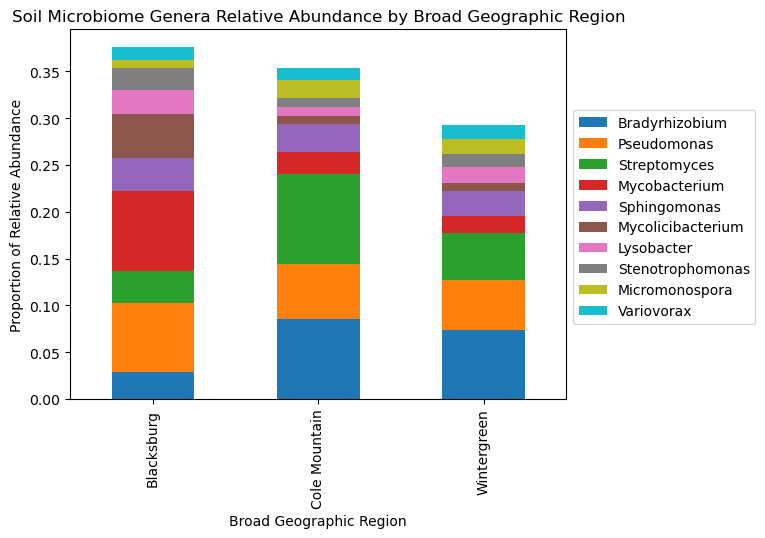

In [101]:
sort_list = ['site_id', 'species', 'BGR']
for sort_id in sort_list:
    df1 = opdf.groupby([sort_id])[taxa_columns].mean()
    df1 = df1.reset_index()
    new_columns = df1[taxa_columns].sum().nlargest(10)
    col_list = []
    for i in new_columns.axes[0]:
        col_list.append(i)
    col_list.append(sort_id)
    df2 = df1[col_list]
    ax = df2.plot.bar(x = sort_id, stacked=True)
    
    name_dict = {'site_id': 'Site ID', 'species': 'Species', 'BGR': 'Broad Geographic Region'}
    graph_inf = name_dict[sort_id] 
    
    ax.set_xlabel(graph_inf)
    ax.set_ylabel('Proportion of Relative Abundance')
    ax.set_title('Soil Microbiome Genera Relative Abundance by ' + graph_inf)
    ax.legend(bbox_to_anchor=(1,0.8))
    
    if sort_id == 'site_id':
        plt.savefig('./soil_microbiome_figures/fig_2_a.pdf', dpi=300, bbox_inches='tight')
    elif sort_id == 'species':
        plt.savefig('./soil_microbiome_figures/fig_2_b.pdf', dpi=300, bbox_inches='tight')
    elif sort_id == 'BGR':
        plt.savefig('./soil_microbiome_figures/fig_2_c.pdf', dpi=300, bbox_inches='tight')

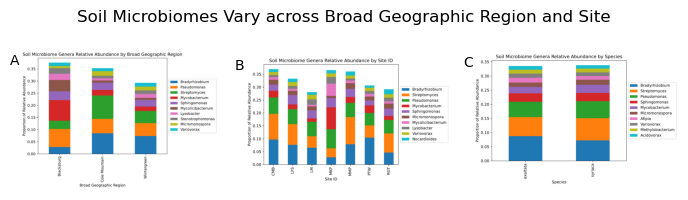

In [106]:
img1=convert_from_path('./soil_microbiome_figures/fig_2_a.pdf')
img2=convert_from_path('./soil_microbiome_figures/fig_2_b.pdf')
img3=convert_from_path('./soil_microbiome_figures/fig_2_c.pdf')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))

ax[0].imshow(img3[0])
ax[1].imshow(img1[0])
ax[2].imshow(img2[0])

# plot 2 subplots
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')


ax[0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Microbiomes Vary across Broad Geographic Region and Site')
plt.tight_layout()
plt.show()

fig.savefig('./soil_microbiome_figures/figure_2.pdf', bbox_inches='tight', dpi = 1000)

### Soil Microbiome Figure 3

In [4]:
taxa_level = 'Genera'
table_name = 'tSoilMicrobe' + taxa_level
tables_to_join = [table_name, "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df = full_df.T.drop_duplicates().T
full_df.shape
full_df.rename(columns={'genera': 'taxa'}, inplace=True)
opdf = full_df.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='taxa', values='relative_abundance')

origin_pivoted_df = opdf.copy()
row_sum = origin_pivoted_df.sum(axis=1)

origin_pivoted_df = origin_pivoted_df.reset_index()

genera_col = origin_pivoted_df.columns
genera_col = genera_col.drop(['sample_id','site_id', 'species', 'V2'])

sub_pivot = origin_pivoted_df[genera_col].astype(float)

for row in range(sub_pivot.shape[0]):
    sub_pivot.loc[row] = sub_pivot.loc[row]/row_sum[row]

new_sum = sub_pivot.sum(axis=1)
new_sum

origin_pivoted_df[genera_col] = sub_pivot

origin_pivoted_df.head()

row_sum = origin_pivoted_df[genera_col].sum(axis=1)

opdf = origin_pivoted_df.copy()
opdf = opdf.reset_index()

opdf = opdf.fillna(0)  
col_list1 = []
for i in opdf.columns:
    col_list1.append(i.split('|')[-1])
opdf.columns = col_list1

taxa_columns = opdf.columns
taxa_columns = taxa_columns.drop(['sample_id','site_id', 'species', 'V2'])

In [5]:
site_list = opdf['site_id']

opdf['BGR'] = site_list

opdf['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
opdf = opdf[opdf["BGR"].isin([0,1,2,3])]

opdf['BGR'] = opdf['BGR'].replace([0], 'Wintergreen')
opdf['BGR'] = opdf['BGR'].replace([1], 'Cole Mountain')
opdf['BGR'] = opdf['BGR'].replace([2], 'Blacksburg')
opdf['BGR'] = opdf['BGR'].replace([3], 'HR')

In [6]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]

In [38]:
opdf = opdf.drop(['index'], axis = 1)
opdf = opdf.reset_index(drop=True)
opdf.columns.name = None
opdf.head()

sample_id site_id  species        V2  Candidatus Korarchaeum  Acidilobus  \
0     CMB10     CMB  syriaca  0.999777                     0.0         0.0   
1     CMB11     CMB  syriaca  1.000000                     0.0         0.0   
2     CMB13     CMB  syriaca  0.989131                     0.0         0.0   
3     CMB15     CMB  syriaca  0.998548                     0.0         0.0   
4     CMB16     CMB  syriaca  0.999243                     0.0         0.0   

   Caldisphaera  Aeropyrum  Desulfurococcus  Ignicoccus  ...  Iridovirus  \
0           0.0   0.000048              0.0         0.0  ...         0.0   
1           0.0   0.000000              0.0         0.0  ...         0.0   
2           0.0   0.000000              0.0         0.0  ...         0.0   
3           0.0   0.000000              0.0         0.0  ...         0.0   
4           0.0   0.000000              0.0         0.0  ...         0.0   

   Phix174microvirus  Hokovirus  Klosneuvirus  Tupanvirus  Alphapartitivirus  \
0                0.0        0.0       0.00000         0.0                0.0   
1                0.0        0.0       0.00000         0.0                0.0   
2                0.0        0.0       0.00000         0.0                0.0   
3                0.0        0.0       0.00000         0.0                0.0   
4                0.0        0.0       0.00018         0.0                0.0   

   Bracovirus  Pandoravirus            BGR  seq_id  
0         0.0           0.0  Cole Mountain       3  
1         0.0           0.0  Cole Mountain       3  
2         0.0           0.0  Cole Mountain       3  
3         0.0           0.0  Cole Mountain       3  
4         0.0           0.0  Cole Mountain       3  

[5 rows x 2532 columns]

In [43]:
df = opdf.copy()

In [44]:
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


In [45]:
X = df[taxa_columns]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

drop_indexs = []
for i in enumerate(principal_components):
    if i[1][0] > 0.5:
        print(i)
        drop_indexs.append(i[0])
    if i[1][1] > 0.5:
        print(i)
        drop_indexs.append(i[0])
        
df = df.drop(index=drop_indexs)

(47, array([0.69378711, 0.02211984]))


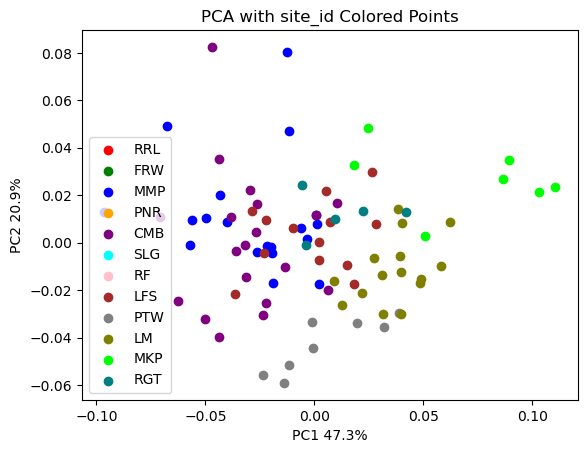

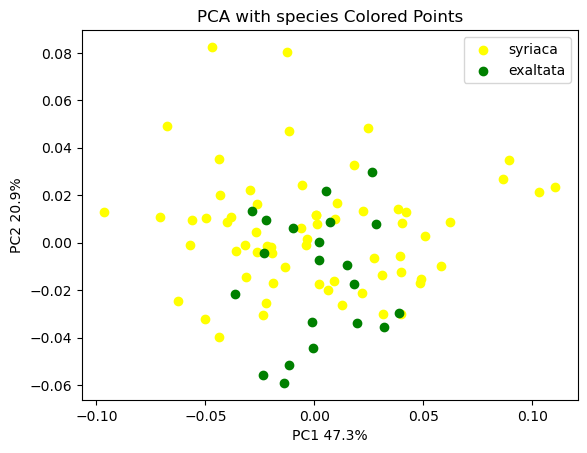

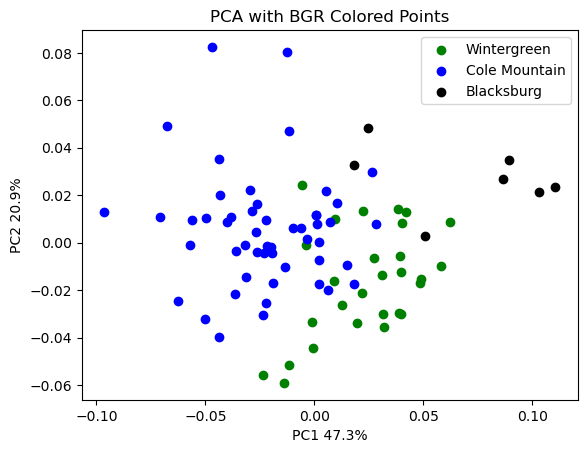

In [49]:
X = df[taxa_columns]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        fig.savefig('./soil_microbiome_figures/fig_3_a.pdf', dpi=300, bbox_inches='tight')
    elif graph_type == 'species':
        fig.savefig('./soil_microbiome_figures/fig_3_b.pdf', dpi=300, bbox_inches='tight')
    else:
        fig.savefig('./soil_microbiome_figures/fig_3_c.pdf', dpi=300, bbox_inches='tight')


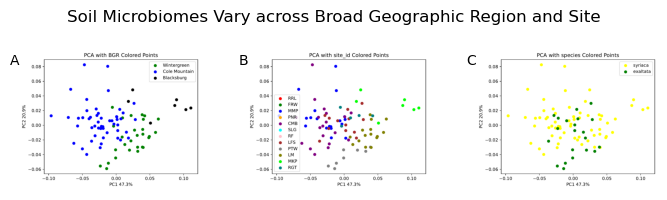

In [50]:
img1=convert_from_path('./soil_microbiome_figures/fig_3_a.pdf')
img2=convert_from_path('./soil_microbiome_figures/fig_3_b.pdf')
img3=convert_from_path('./soil_microbiome_figures/fig_3_c.pdf')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7, 2))

ax[0].imshow(img3[0])
ax[1].imshow(img1[0])
ax[2].imshow(img2[0])

# plot 2 subplots
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')


ax[0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Microbiomes Vary across Broad Geographic Region and Site')
plt.tight_layout()
plt.show()

fig.savefig('./soil_microbiome_figures/figure_3.pdf', bbox_inches='tight', dpi = 1000)

### Calculate Proportions of 10 most abundant Genera based on Relative Abundance

In [14]:
taxa_level = 'Genera'
table_name = 'tSoilMicrobe' + taxa_level
tables_to_join = [table_name, "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df = full_df.T.drop_duplicates().T
full_df.shape
full_df.rename(columns={'genera': 'taxa'}, inplace=True)
opdf = full_df.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='taxa', values='relative_abundance')
opdf = opdf.reset_index()
opdf = opdf.fillna(0)    
col_list1 = []
for i in opdf.columns:
    col_list1.append(i.split('|')[-1])
opdf.columns = col_list
taxa_columns = opdf.columns
taxa_columns = taxa_columns.drop(['sample_id','site_id', 'species', 'V2'])

In [15]:
site_list = opdf['site_id']

opdf['BGR'] = site_list

opdf['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
opdf = opdf[opdf["BGR"].isin([0,1,2,3])]

opdf['BGR'] = opdf['BGR'].replace([0], 'Wintergreen')
opdf['BGR'] = opdf['BGR'].replace([1], 'Cole Mountain')
opdf['BGR'] = opdf['BGR'].replace([2], 'Blacksburg')
opdf['BGR'] = opdf['BGR'].replace([3], 'HR')

C:\Users\15404\AppData\Local\Temp\ipykernel_21180\921536217.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  opdf['BGR'] = site_list


In [16]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]

In [53]:
new_columns = df1[taxa_columns].sum().nlargest(10)
top_10_list = []
for i in new_columns.axes[0]:
    top_10_list.append(i)

col_list = top_10_list.copy()

other_col = opdf.columns
other_col = other_col.drop(['sample_id', 'site_id', 'species', 'V2', 'seq_id', 'BGR'])
other_col = other_col.drop(top_10_list)

print(len(top_10_list))
print(len(other_col))

10
2516


In [58]:
top_10_sum = opdf[top_10_list].sum(axis = 1)
other_sum = opdf[other_col].sum(axis = 1)

In [59]:
total_abundance = 0
for i in zip(top_10_sum, other_sum):
    total_abundance+=(i[0]/(i[0]+i[1]))
print(total_abundance/len(top_10_sum))

0.33597005777189587


In [67]:
combined_abundance = []
for i in zip(top_10_sum, other_sum):
    combined_abundance.append((i[0]+i[1]))
print(sum(combined_abundance)/len(combined_abundance))
print(statistics.pstdev(combined_abundance))

16.215830114942516
4.283416226104617


### Calculate average identified abundance for each BGL, Site, and Species

In [2]:
taxa_level = 'Genera'
table_name = 'tSoilMicrobe' + taxa_level
tables_to_join = [table_name, "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df = full_df.T.drop_duplicates().T
full_df.shape
full_df.rename(columns={'genera': 'taxa'}, inplace=True)
opdf = full_df.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='taxa', values='relative_abundance')
opdf = opdf.reset_index()
opdf = opdf.fillna(0)    
col_list1 = []
for i in opdf.columns:
    col_list1.append(i.split('|')[-1])
opdf.columns = col_list1
taxa_columns = opdf.columns
taxa_columns = taxa_columns.drop(['sample_id','site_id', 'species', 'V2'])

In [3]:
site_list = opdf['site_id']

opdf['BGR'] = site_list

opdf['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
opdf = opdf[opdf["BGR"].isin([0,1,2,3])]

opdf['BGR'] = opdf['BGR'].replace([0], 'Wintergreen')
opdf['BGR'] = opdf['BGR'].replace([1], 'Cole Mountain')
opdf['BGR'] = opdf['BGR'].replace([2], 'Blacksburg')
opdf['BGR'] = opdf['BGR'].replace([3], 'HR')

C:\Users\15404\AppData\Local\Temp\ipykernel_22188\921536217.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  opdf['BGR'] = site_list


In [4]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]

In [5]:
opdf.head()

sample_id site_id  species        V2  Candidatus Korarchaeum  Acidilobus  \
0     CMB10     CMB  syriaca  0.999777                     0.0         0.0   
1     CMB11     CMB  syriaca  1.000000                     0.0         0.0   
2     CMB13     CMB  syriaca  0.989131                     0.0         0.0   
3     CMB15     CMB  syriaca  0.998548                     0.0         0.0   
4     CMB16     CMB  syriaca  0.999243                     0.0         0.0   

   Caldisphaera  Aeropyrum  Desulfurococcus  Ignicoccus  ...  Iridovirus  \
0           0.0    0.00068              0.0         0.0  ...         0.0   
1           0.0    0.00000              0.0         0.0  ...         0.0   
2           0.0    0.00000              0.0         0.0  ...         0.0   
3           0.0    0.00000              0.0         0.0  ...         0.0   
4           0.0    0.00000              0.0         0.0  ...         0.0   

   Phix174microvirus  Hokovirus  Klosneuvirus  Tupanvirus  Alphapartitivirus  \
0                0.0        0.0       0.00000         0.0                0.0   
1                0.0        0.0       0.00000         0.0                0.0   
2                0.0        0.0       0.00000         0.0                0.0   
3                0.0        0.0       0.00000         0.0                0.0   
4                0.0        0.0       0.00308         0.0                0.0   

   Bracovirus  Pandoravirus            BGR  seq_id  
0         0.0           0.0  Cole Mountain       3  
1         0.0           0.0  Cole Mountain       3  
2         0.0           0.0  Cole Mountain       3  
3         0.0           0.0  Cole Mountain       3  
4         0.0           0.0  Cole Mountain       3  

[5 rows x 2532 columns]

In [19]:
# Calculate Identified Abundance for Site, BGR, and Species

In [6]:
sort_list = ['site_id', 'BGR', 'species']
for sort_id in sort_list:
    print(sort_id)
    group_list = (taxa_columns.copy()).to_list()
    group_list.append(sort_id)
    df1 = opdf[group_list]
    df1 = df1.groupby([sort_id]).mean()
    df1 = df1.reset_index()
    for i in df1[sort_id]:
        subdf = df1[df1[sort_id] == i]
        print(i + ' Mean:', round(subdf[taxa_columns].sum(axis = 1).to_list()[0], 3))
    print('')

site_id
CMB Mean: 13.562
LFS Mean: 19.358
LM Mean: 13.736
MKP Mean: 17.687
MMP Mean: 19.046
PTW Mean: 15.587
RGT Mean: 13.467

BGR
Blacksburg Mean: 17.687
Cole Mountain Mean: 17.083
Wintergreen Mean: 14.217

species
exaltata Mean: 17.922
syriaca Mean: 15.673



In [12]:
site_list = opdf['site_id'].unique()
for site in site_list:
    print(site, opdf[opdf['site_id'] == site][taxa_columns].sum(axis = 1).std())

print('')
BGR_list = opdf['BGR'].unique()
for bgl in BGR_list:
    print(bgl, opdf[opdf['BGR'] == bgl][taxa_columns].sum(axis = 1).std())

print('')
species_list = opdf['species'].unique()
for spec in species_list:
    print(spec, opdf[opdf['species'] == spec][taxa_columns].sum(axis = 1).std())

CMB 3.435154485620369
LFS 2.7320132289572516
LM 2.595238420247103
MKP 6.857520912186743
MMP 4.055433064828401
PTW 1.1884173342359554
RGT 0.10026690595604786

Cole Mountain 4.413649160217352
Wintergreen 2.156179732421757
Blacksburg 6.857520912186743

syriaca 4.550282316189575
exaltata 2.9143899356101444


In [18]:
opdf[taxa_columns].sum(axis = 1).std()

4.3082478325407205